In [60]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import cv2
import numpy as np
from cv import *

## Calibration and image distortion

In [134]:
#img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.imread('test_images/x-test4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
objpoints, imgpoints = load_calibration_parameters(6, 9)
img_undistort = undistort(img, objpoints, imgpoints)

height, weight = img.shape[0], img.shape[1]
src = [(570, 470), (722, 470), (1110, 720), (220, 720)]
dst = [(320, 0), (920, 0), (920, 720), (320, 720)]

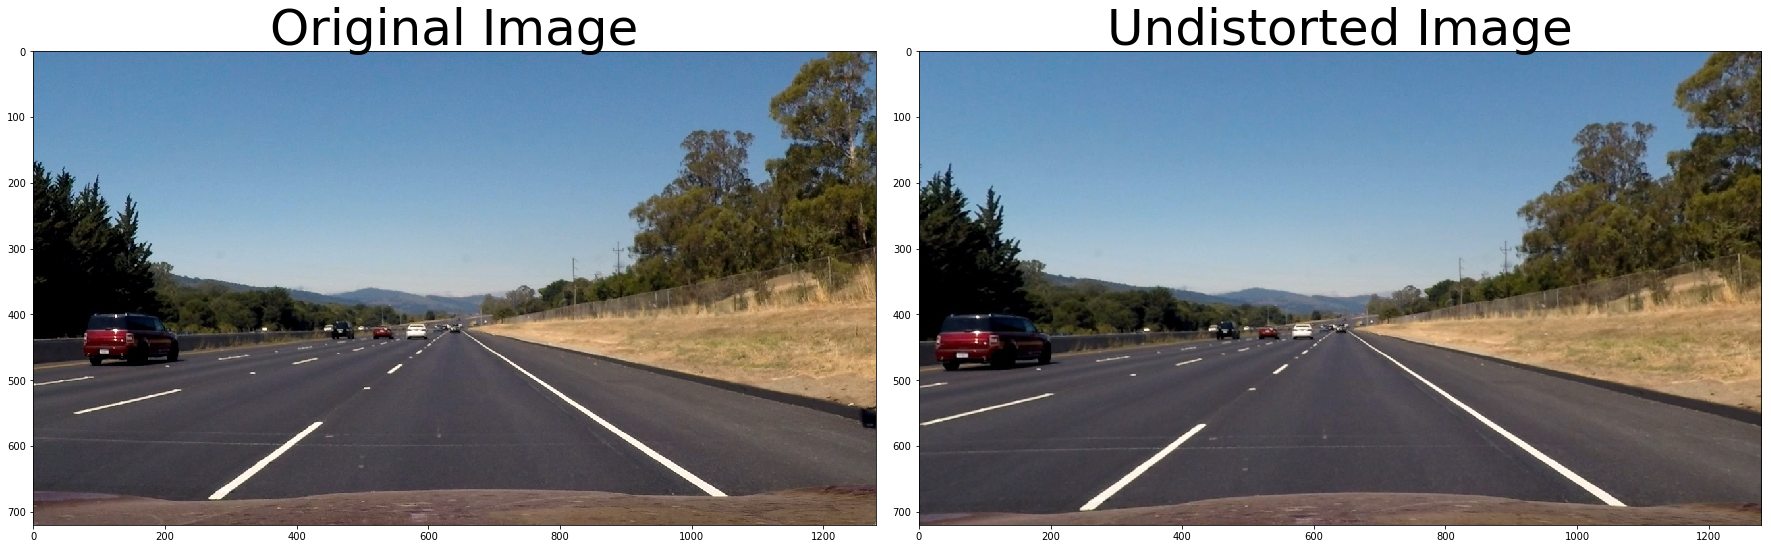

In [135]:
plot_comparison(
    img,
    img_undistort,
    title1='Original Image',
    title2='Undistorted Image'
)

## Exploring color channels

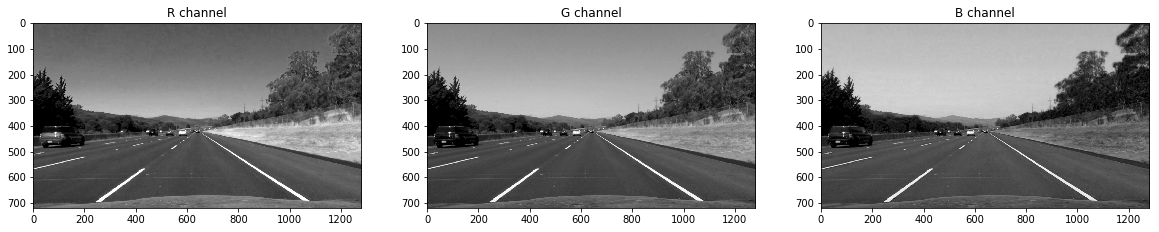

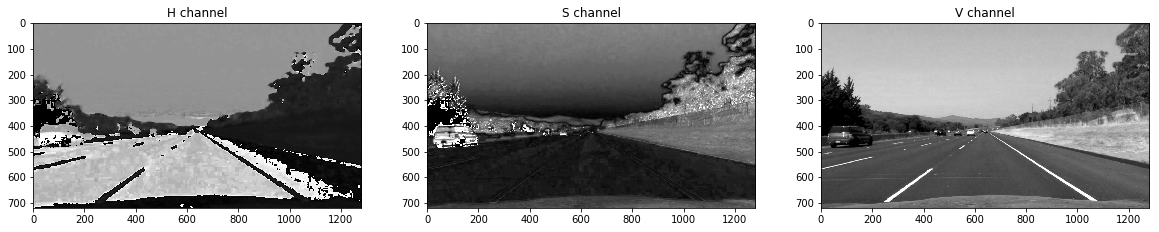

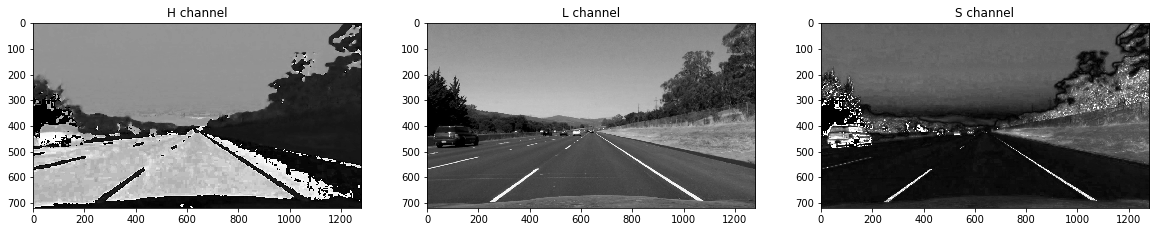

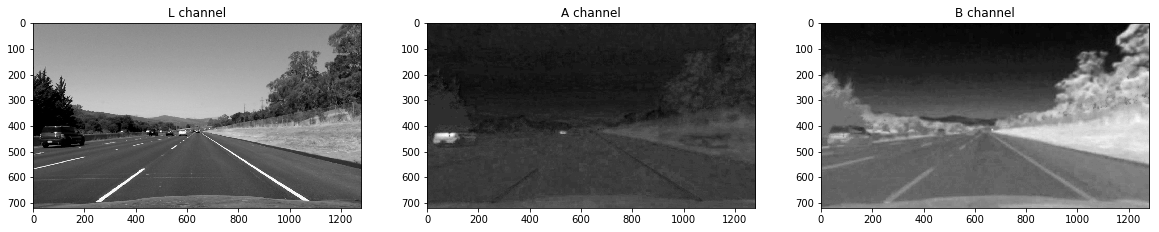

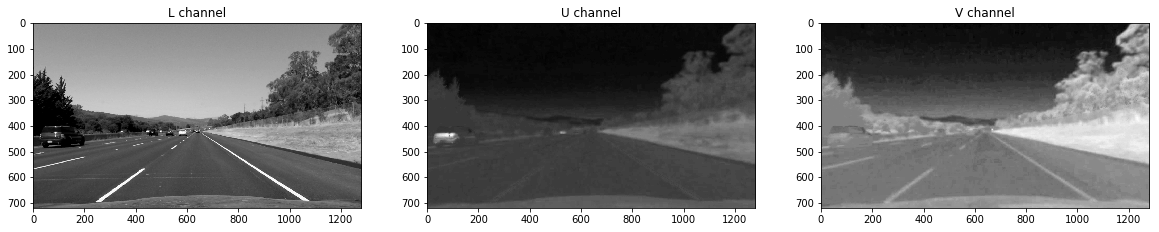

In [136]:
def plot_channels(img, channels='RGB'):
    # Isolate RGB channels
    c1 = img[:, :, 0]
    c2 = img[:, :, 1]
    c3 = img[:, :, 2]

    # Visualize the individual color channels
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title('%s channel' % channels[0])
    ax1.imshow(c1, cmap='gray')
    ax2.set_title('%s channel' % channels[1])
    ax2.imshow(c2, cmap='gray')
    ax3.set_title('%s channel' % channels[2])
    ax3.imshow(c3, cmap='gray')

plot_channels(img_undistort, channels='RGB')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HSV), channels='HSV')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS), channels='HLS')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2LAB), channels='LAB')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2LUV), channels='LUV')

canny


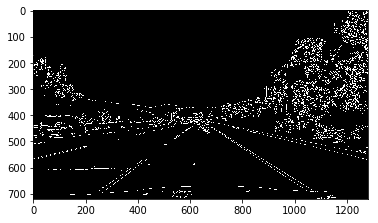

red threshold


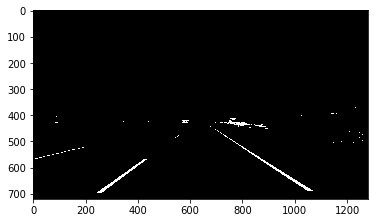

saturation threshold


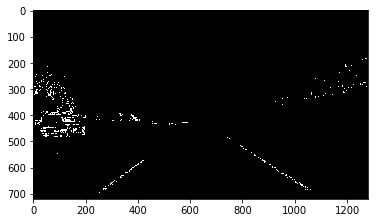

sobel x


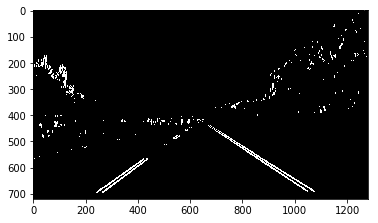

yellow threshold


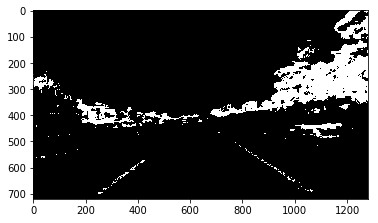

white threshold


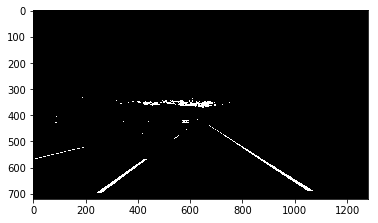

In [137]:
def white_threshold(img, thresh=(0, 255)):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    binary_output = np.zeros_like(r)
    binary_output[(r >= thresh[0]) & (r <= thresh[1]) & 
                  (g >= thresh[0]) & (g <= thresh[1]) & 
                  (b >= thresh[0]) & (b <= thresh[1])] = 1
    return binary_output

def channel_threshold(img, channel=0, thresh=(0, 255)):
    c = img[:, :, channel]
    binary_output = np.zeros_like(c)
    binary_output[(c >= thresh[0]) & (c <= thresh[1])] = 1
    return binary_output

def combine_threshold(binary1, binary2):
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 1
    return combined_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # take the gradient in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    # calculate the magnitude
    mag_sobel = np.sqrt(sobelx ** 2)

    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))

    # create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # inversed the mask, so can be combined with color threshold later on...
    binary_output = 1 - binary_output    
    return binary_output

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# canny
print('canny')
test_img0 = canny(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2GRAY), 0, 200)
plt.imshow(test_img0, cmap='gray')
plt.show()

# red threshold
print('red threshold')
test_img1 = channel_threshold(img_undistort, channel=0, thresh=(220, 255))
plt.imshow(test_img1, cmap='gray')
plt.show()

# saturation threshold
print('saturation threshold')
test_img2 = channel_threshold(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS), channel=2, thresh=(240, 255))
plt.imshow(test_img2, cmap='gray')
plt.show()

# sobel-x
print('sobel x')
test_img3 = mag_thresh(img_undistort, sobel_kernel=21, thresh=(0, 60))
plt.imshow(test_img3, cmap='gray')
plt.show()

# yellow threshold
print('yellow threshold')
test_img4 = channel_threshold(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HSV), channel=0, thresh=(20, 30))
plt.imshow(test_img4, cmap='gray')
plt.show()

# white threshold
print('white threshold')
test_img5 = white_threshold(img_undistort, thresh=(190, 255))
plt.imshow(test_img5, cmap='gray')
plt.show()

# composition
test_img6 = combine_threshold(test_img1, test_img3)
test_img6 = combine_threshold(test_img6, test_img4)
test_img6 = combine_threshold(test_img6, test_img5)

## Gradient and Threshold

In [138]:
def compose_threshold(img):
    # white threshold
    img1 = white_threshold(img, thresh=(190, 255))    
    # red threshold
    img2 = channel_threshold(img, channel=0, thresh=(220, 255))
    # sobel-x
    img3 = mag_thresh(img, sobel_kernel=21, thresh=(0, 40))
    # yellow threshold
    img4 = channel_threshold(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), channel=0, thresh=(20, 30))

    result = combine_threshold(img1, img2)
    result = combine_threshold(result, img3)
    result = combine_threshold(result, img4)
    return result

img_sobel = compose_threshold(img_undistort)

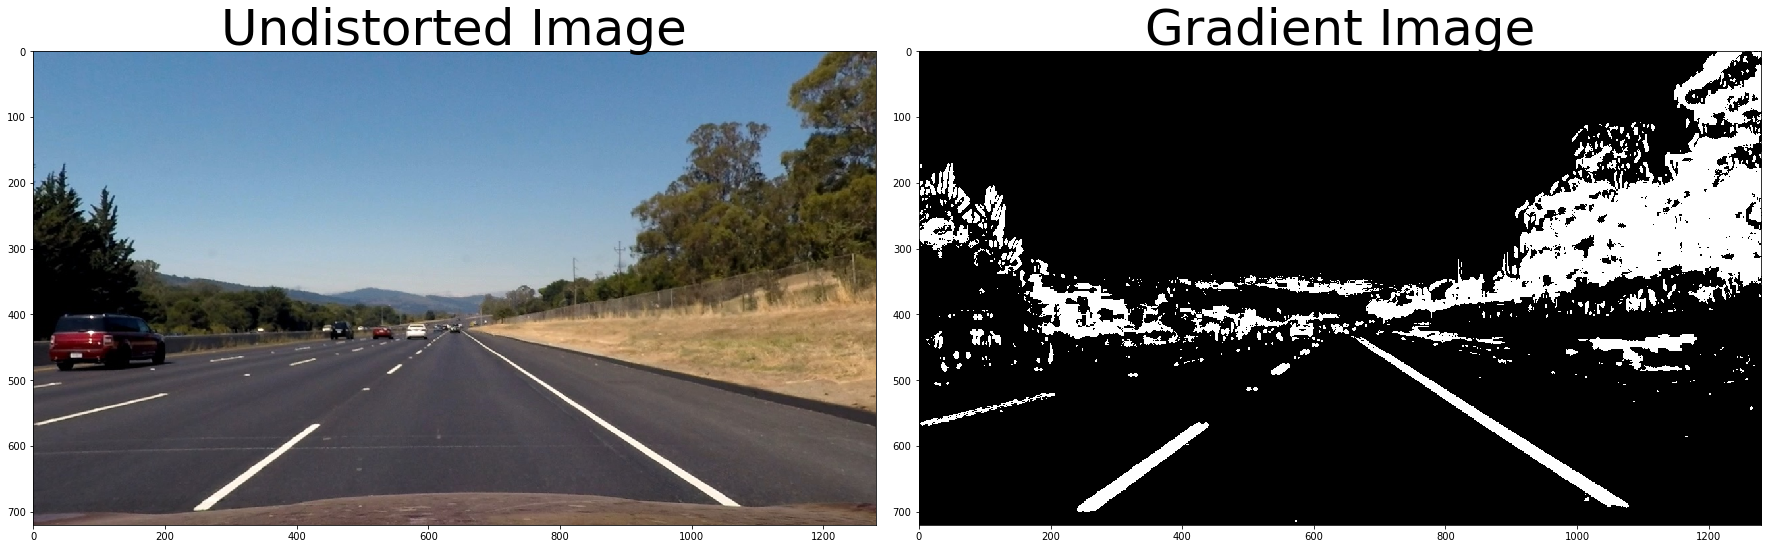

In [139]:
plot_comparison(
    img_undistort,
    img_sobel,
    title1='Undistorted Image',
    title2='Gradient Image',
    cmap2='gray'
)

## Region of Interest

[[[ 510  470]
  [ 782  470]
  [1170  670]
  [ 160  670]]]


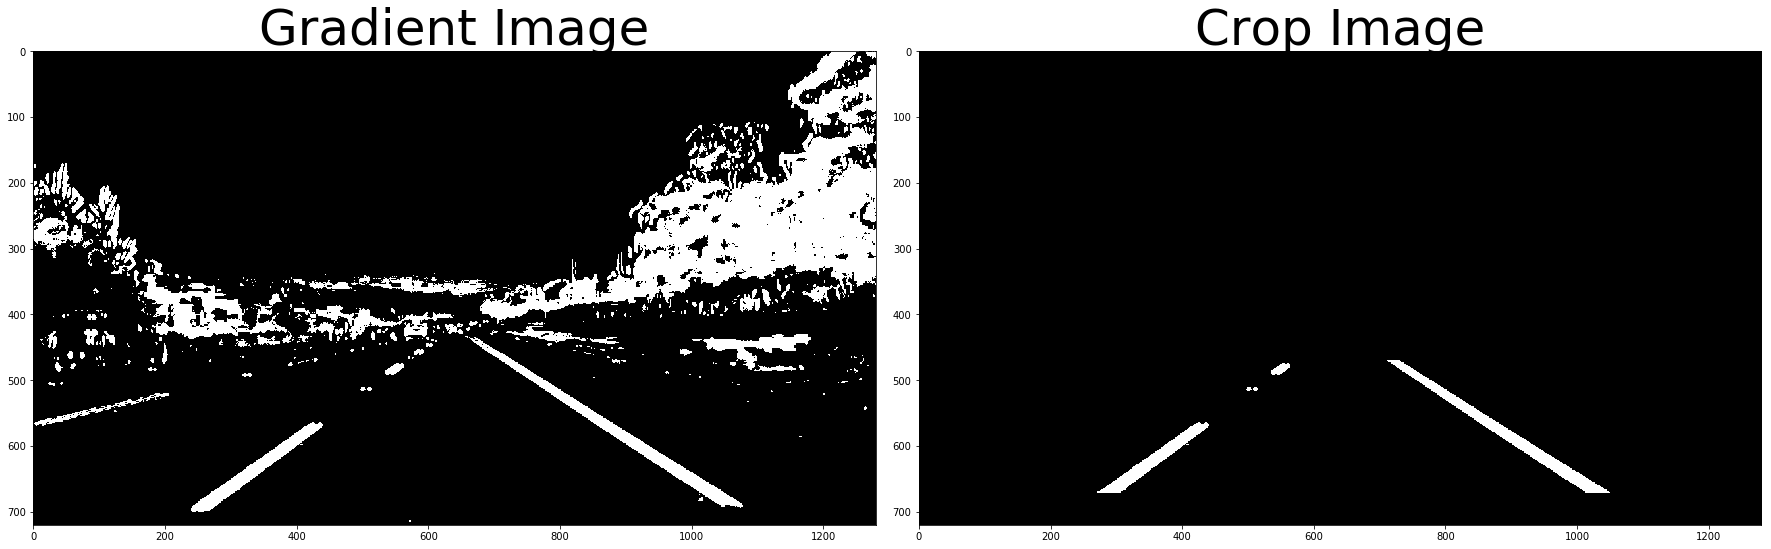

In [140]:
vertices = np.int32([[
    (src[0][0] - 60, src[0][1]),
    (src[1][0] + 60, src[1][1]),
    (src[2][0] + 60, src[2][1] - 50),
    (src[3][0] - 60, src[3][1] - 50)]]
)
print(vertices)
img_crop = region_of_interest(img_sobel, vertices)
plot_comparison(
    img_sobel,
    img_crop,
    title1='Gradient Image',
    title2='Crop Image',
    cmap1='gray',
    cmap2='gray'
)

## Perspective Transform

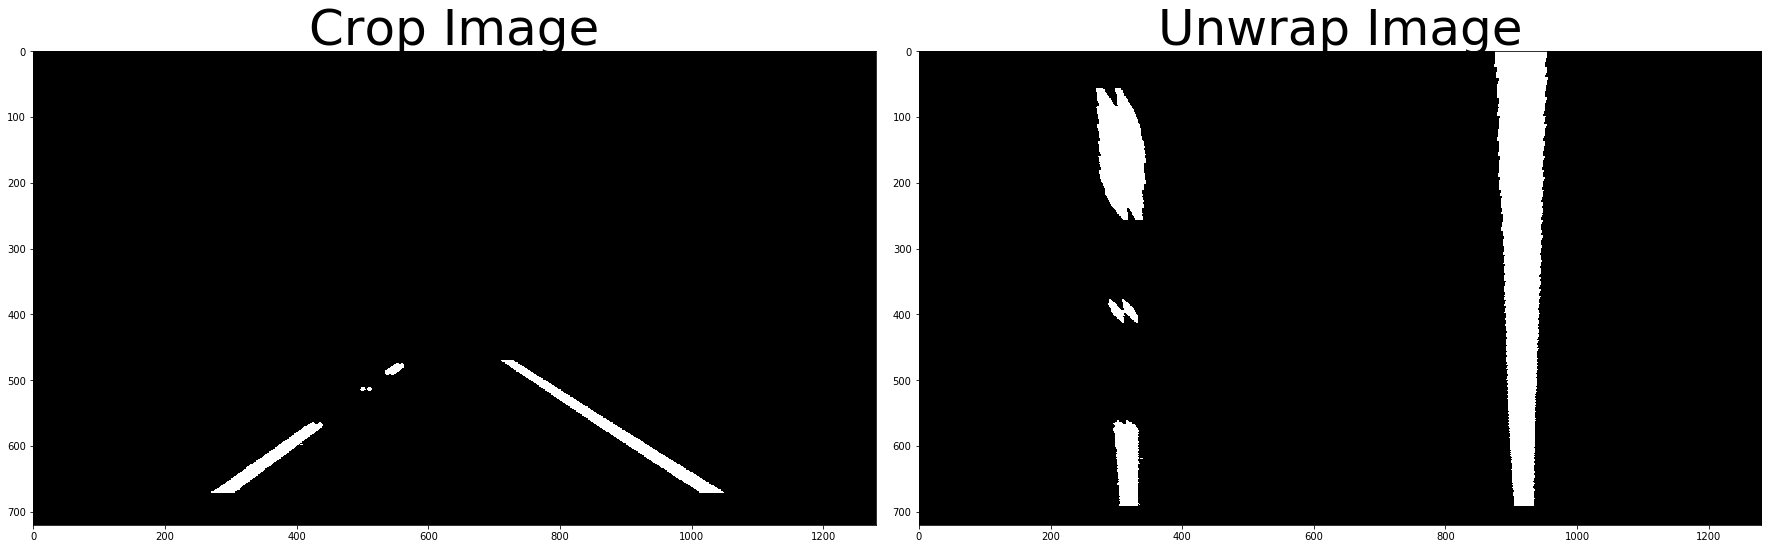

In [141]:
img_unwarp, M, Minv = unwarp(img_crop, np.float32(src), np.float32(dst))
plot_comparison(
    img_crop,
    img_unwarp,
    title1='Crop Image',
    title2='Unwrap Image',
    cmap1='gray',
    cmap2='gray'    
)

## Image Histogram

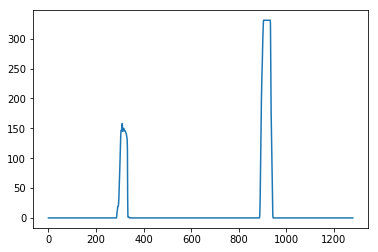

In [142]:
h = histogram(img_unwarp)
plot_histogram(h)

## Fit Polynomial

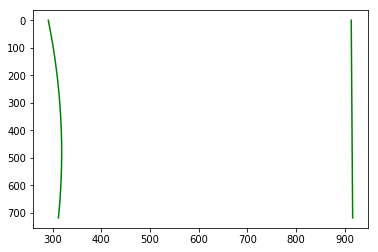

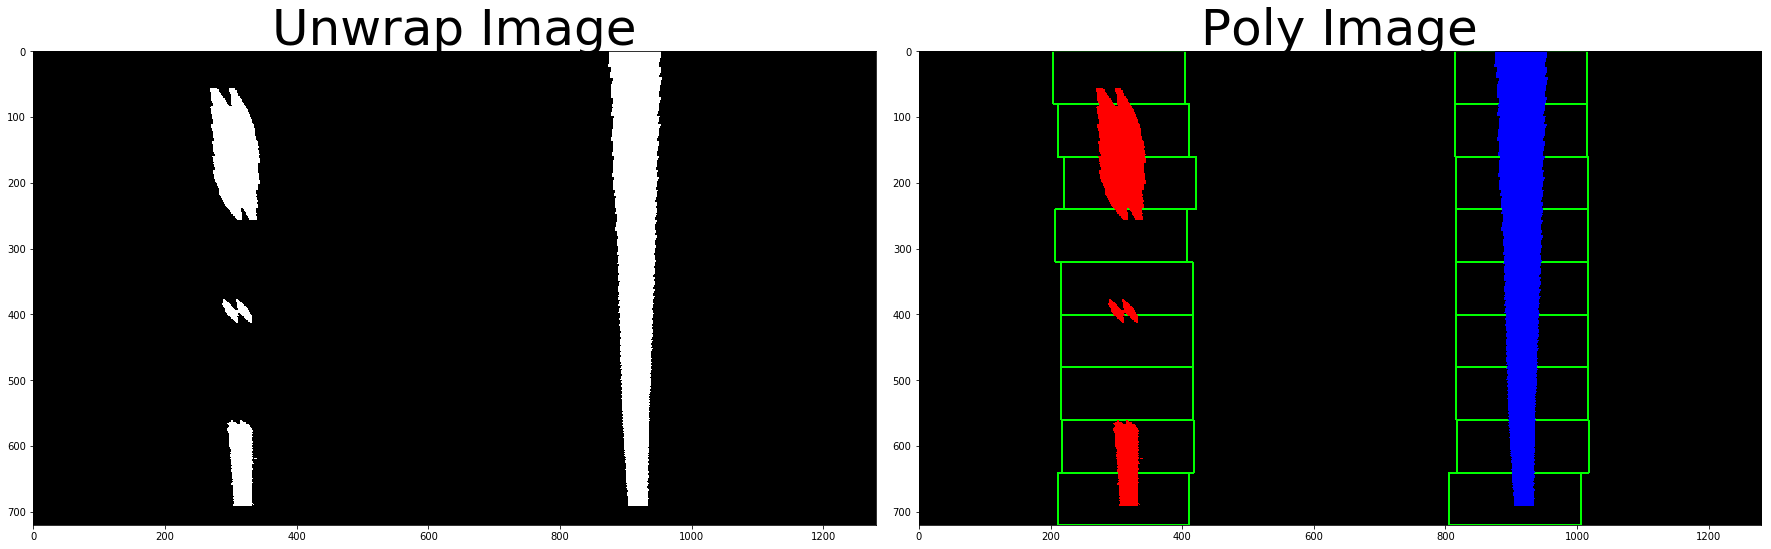

In [143]:
def fit_polynomial(img, verbose=0):
    # find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

    # fitting a second order polynomial
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    y_eval = np.max(ploty)
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    # colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    if verbose:
        plt.plot(left_fitx, ploty, color='green')
        plt.plot(right_fitx, ploty, color='green')
        plt.gca().invert_yaxis()  # to visualize as we do the images

    left_curverad, right_curverad = measure_curvature_real(y_eval, leftx, lefty, rightx, righty)
    return left_fitx, right_fitx, left_curverad, right_curverad, out_img

left_fit, right_fit, left_curverad, right_curverad, img_poly = fit_polynomial(img_unwarp, verbose=1)
plot_comparison(
    img_unwarp,
    img_poly,
    title1='Unwrap Image',
    title2='Poly Image',
    cmap1='gray',
    cmap2='gray'
)


## Drawing the lane

In [144]:
img_out = draw_lane(img_undistort, img_sobel, left_fit, right_fit, Minv)

In [145]:
def overlay(img1, img2, x_offset=50, y_offset=50):    
    img1[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2
    return img1

def put_text(img, text, font=cv2.FONT_HERSHEY_SIMPLEX, x_offset=0, y_offset=0, scale=1, color=(255, 255, 255), line_type=2):
    result = np.copy(img)
    return cv2.putText(result, text, (x_offset, y_offset), font, scale, color, line_type)

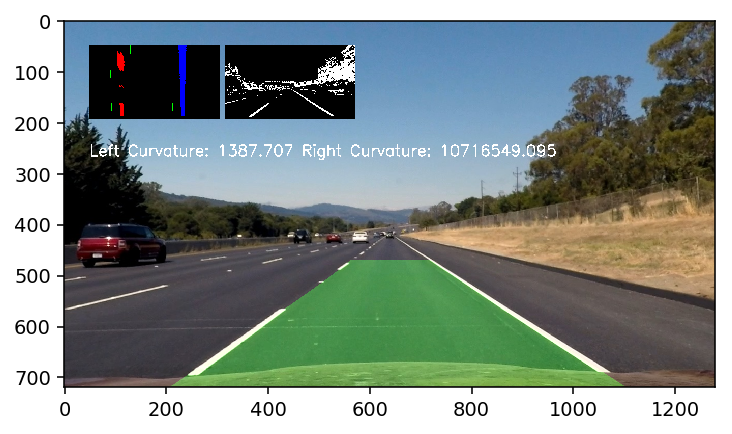

In [146]:
img_overlay1 = cv2.resize(img_poly, (256, 144))
img_overlay2 = cv2.resize(cv2.cvtColor(255*img_sobel, cv2.COLOR_GRAY2RGB), (256, 144))
img_result = img_out
img_result = overlay(img_result, img_overlay1, x_offset=50, y_offset=50)
img_result = overlay(img_result, img_overlay2, x_offset=316, y_offset=50)

text = 'Left Curvature: %.3f Right Curvature: %.3f' % (left_curverad, right_curverad)
img_result = put_text(img_result, text, x_offset=50, y_offset=266)

fig, ax = plt.subplots(dpi=140)
ax.imshow(img_result)
plt.show()